# Projet Notations de films 

Introduction ? 

### importation des librairies et fichiers

In [1]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install lxml
!pip install aiohttp
!pip install nest_asyncio

import asyncio
import aiohttp
import pandas as pd
from bs4 import BeautifulSoup
import re
import nest_asyncio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.6 MB/s eta 0:00:00
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.4 MB/s eta 0:00:00


In [7]:
# Importation des librairies
import csv

# import seaborn as sns #pas besoin si utilise fonctions
import matplotlib.pyplot as plt

# Regression
import statsmodels.api as sm
from statsmodels.formula.api import rlm 

In [8]:
import os

# Importation des fichiers python (contenant des fonctions) crées dans le cadre des 3 parties du projet :

for f in os.listdir('A_Base_de_données'):
    if f.endswith('.py') and f != 'web_scrapping.py': # A gérer !!!!!
        module_name = os.path.splitext(f)[0]
        exec(f"from A_Base_de_données.{module_name} import *")


for f in os.listdir('B_Analyse_descriptive'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from B_Analyse_descriptive.{module_name} import *")


for f in os.listdir('C_Modele'):
    if f.endswith('.py'):
        module_name = os.path.splitext(f)[0]
        exec(f"from C_Modele.{module_name} import *")


## I - Création de la base de données

### Webscrapping AlloCiné

In [ ]:
# Récupération d'une liste de films qui possèdent tous une note moyenne de spectateur et une note moyenn de presse entre l'année .... et l'année .....
base_films = get_base_films(2010, 2023)


# Récupération pour chaque film de différentes caractériques
nest_asyncio.apply()
base_films_enrichie, presse = get_carac_film(base_films)


In [ ]:
# Exportation en CSV => mettre en commentaire lors du rendu final afin que cela soit toujours le même CSV qui soit utilisé par la suite
from pathlib import Path 
filepath = Path('/home/onyxia/work/Projet_Cin-/A_Base_de_données/base_allociné_2010_2023.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
base_films_enrichie.to_csv(filepath)

In [4]:
# Lecture des bases CSV : 

# Base de films : contenant diverses caractéristiques sur les films
base_films = pd.read_csv('A_Base_de_données/base_films_2010_2023.csv')


# Base presse : contenant la note de chaque presse pour chaque film
presse = pd.read_csv('A_Base_de_données/presse_2010_2023.csv')


### Traitement et création de variables

Base presse

In [6]:
# Traduction des notes en numérique (Très bien => 4, etc)
presse_notes = equivalence_notes(presse)
presse_notes.head()

/home/onyxia/work/Projet_Cin-/A_Base_de_données/mise_en_forme.py:94: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  notes = dataframe.replace(equivalences)


,identifiant,L'Express,Télérama,Brazil,Les Fiches du Cinéma,Les Inrockuptibles,Le Figaroscope,Cahiers du Cinéma,Le Point,Bande à part,...,Libération,Slate,Voici,Studio Magazine,Studio Ciné Live,Dernières Nouvelles d'Alsace,Le Soir,L'Ecran Fantastique,Culturopoing.com,aVoir-aLire.com
0,173528,3,1,NaN,NaN,1,1.0,1,3,NaN,...,1,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
1,146632,2,2,3.0,NaN,1,5.0,1,4,NaN,...,1,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN
2,133588,3,3,NaN,NaN,3,4.0,NaN,3,NaN,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132039,3,4,3.0,NaN,4,3.0,2,5,NaN,...,3,NaN,NaN,NaN,5,NaN,NaN,2.0,NaN,NaN
4,123534,5,3,4.0,NaN,NaN,4.0,NaN,3,NaN,...,NaN,NaN,NaN,NaN,4,NaN,NaN,4.0,NaN,NaN


base films

In [21]:
# Ajout du genre des réalisateurs
table_films = get_genre_individuel(base_films, 'auteur')

# Aperçu du nb de réalisateurs m vs f vs autres
table_films['genre_ind'].value_counts()

genre_ind
m      3946
f       901
m,f     211
f,m      50
Name: count, dtype: int64

In [22]:
# Conversion des notes en décimale
table_films['spectateur'] = table_films['spectateur'].apply(mise_en_forme_decimale)
table_films['presse'] = table_films['presse'].apply(mise_en_forme_decimale)

# Création variable : différence de notation entre spectateur et presse
table_films['diff_notation'] = table_films['spectateur']-table_films['presse']

In [23]:
# Création de la variable année
table_films = get_annee(table_films, 'date')

In [24]:
# Conversion de la durée en minutes
table_films['durée'] = table_films['durée'].astype('string')
table_films['duree_min'] = table_films['durée'].apply(duree_en_minutes)

In [25]:
table_films.head()

,genre_ind,titre,identifiant,date,durée,auteur,spectateur,presse,genre1,genre2,...,budget,langues,format_production,couleur,format_audio,format_projection,num_visa,diff_notation,annee,duree_min
0,m,Le Grand jeu,233140,3 janvier 2018,2h 20min,Aaron Sorkin,3.9,3.5,Biopic,Drame,...,-,Anglais,-,Couleur,-,-,147906,0.4,2018,140.0
1,m,Les Sept de Chicago,130085,16 octobre 2020,2h 09min,Aaron Sorkin,4.2,4.4,Drame,Historique,...,-,Anglais,-,Couleur,-,-,-,-0.2,2020,129.0
2,m,USS Greyhound - La bataille de l'Atlantique,250108,10 juillet 2020,1h 31min,Aaron Schneider,3.6,2.7,Drame,Historique,...,-,Anglais,-,Couleur,-,-,-,0.9,2020,91.0
3,m,Being the Ricardos,289496,21 décembre 2021,2h 05min,Aaron Sorkin,3.3,3.6,Biopic,Drame,...,-,Anglais,-,Couleur,-,-,-,-0.3,2021,125.0
4,m,Le Secret de la cité perdue,287082,20 avril 2022,1h 52min,Aaron Nee,2.4,2.7,Action,Aventure,...,-,Anglais,-,Couleur,-,-,156428,-0.3,2022,112.0


## II -  Analyse descriptive

### 1) Analyses descriptives générales sur les films de toutes nationalités

### Base CNC : Analyse du type de devis, obtenus par les réalisateurs vs les réalisatrices

Une base du CNC nous donne ce type d'information : les sociétés productrices et distributrices des films, chaînes de télévision partenaires en préachat. Je veux étudier les différences de montant des devis selon le genre du réalisateur.


In [2]:
#Ici, j'importe les données du CNC en utilisant un API.
import requests
import pandas as pd
api_root = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/cnc-production-cinematographique-liste-des-films-agrees/exports/json?limit=-1"
response = requests.get(api_root)
films_cnc_brut = response.json() #je mets tout dans un dico json
print(response.content[:1000])

films_cnc = pd.json_normalize(films_cnc_brut) 
films_cnc = films_cnc.set_index('visa')
films_cnc.head(10)

b'[{"visa": "117042", "titre": "BYE BYE BLONDIE", "realisateur": "DESPENTES Virginie", "producteurs": "MASTER MOVIES / RED STAR CINEMA / WILD BUNCH", "devis": 4103906.0, "genre": "Fiction", "eof": null, "rang": "2", "asr": "avant", "payante": null, "clair": null, "nationalite": ["France", "Belgique", "Suisse"], "date": "2010", "decomposition": "France-65 / Belgique-21 / Suisse-14", "aides": ["Sofica"]},{"visa": "127028", "titre": "DE L\'HUILE SUR LE FEU", "realisateur": "BENAMOU Nicolas", "producteurs": "AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / TF1 DROITS AUDIOVISUELS / UGC IMAGES", "devis": 3320336.0, "genre": "Fiction", "eof": null, "rang": "1", "asr": null, "payante": null, "clair": null, "nationalite": ["France"], "date": "2010", "decomposition": "France-100", "aides": ["Sofica", "Cr\\u00e9dit D\'impot"]},{"visa": "124421", "titre": "DES JEUNES GENS MODERNES", "realisateur": "DE MISSOLZ J\\u00e9r\\u00f4me", "producteurs": "ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRODUCTIONS

,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides
visa,,,,,,,,,,,,,,
117042,BYE BYE BLONDIE,DESPENTES Virginie,MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,None,"[France, Belgique, Suisse]",2010,France-65 / Belgique-21 / Suisse-14,[Sofica]
127028,DE L'HUILE SUR LE FEU,BENAMOU Nicolas,AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / ...,3320336.0,Fiction,None,1,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot]"
124421,DES JEUNES GENS MODERNES,DE MISSOLZ Jérôme,ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRO...,815248.0,Documentaire,None,2,None,None,None,[France],2010,France-100,[Crédit D'impot]
123383,EXERCICE DE L'ETAT (L'),SCHOELLER Pierre,ARCHIPEL 35 / FRANCE 3 CINEMA,6548121.0,Fiction,None,3,avant,None,None,"[France, Belgique]",2010,France-80 / Belgique-20,"[Sofica, Crédit D'impot]"
124350,MA PART DU GATEAU,KLAPISCH Cédric,CE QUI ME MEUT - MOTION PICTURES / FRANCE 2 CI...,7885486.0,Fiction,None,3,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot, Aide Régionale]"
122385,MARQUIS (LE),FARRUGIA Dominique,FARRUDG ENTERTAINMENT WORLDWIDE / PATHE PRODUC...,8880926.0,Fiction,None,3,None,None,None,[France],2010,France-100,[Crédit D'impot]
126154,PROIE (LA),VALETTE Eric,BRIO FILMS / STUDIOCANAL / TF1 FILMS PRODUCTION,9706711.0,Fiction,None,3,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot, Aide Régionale]"
125930,UNE EDUCATION NORVEGIENNE,LIEN Jens,LES FILMS D'ANTOINE,3214636.0,Fiction,None,3,None,None,None,"[Norvege, Suede, France, Danemark]",2010,Norvege-66 / Suede-13 / France-10 / Danemark-10,None
115135,VOIE RAPIDE,RODRIGUEZ Christophe,SESAME FILMS,849880.0,Fiction,None,1,None,None,None,[France],2010,France-100,"[Sofica, Aide Régionale]"


In [3]:
#Création d'une typologie des devis (je reprends les critères de l'article)
films_cnc["type_de_devis"] = pd.cut(films_cnc.devis, [0,2000000,4000000,7000000, 16000000], right=False)
films_cnc["type_de_devis"]= films_cnc["type_de_devis"].cat.rename_categories(["catégorie 1", "catégorie 2", "catégorie 3", "catégorie 4"])
films_cnc.head()


,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides,type_de_devis
visa,,,,,,,,,,,,,,,
117042,BYE BYE BLONDIE,DESPENTES Virginie,MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,None,"[France, Belgique, Suisse]",2010,France-65 / Belgique-21 / Suisse-14,[Sofica],catégorie 3
127028,DE L'HUILE SUR LE FEU,BENAMOU Nicolas,AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / ...,3320336.0,Fiction,None,1,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot]",catégorie 2
124421,DES JEUNES GENS MODERNES,DE MISSOLZ Jérôme,ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRO...,815248.0,Documentaire,None,2,None,None,None,[France],2010,France-100,[Crédit D'impot],catégorie 1
123383,EXERCICE DE L'ETAT (L'),SCHOELLER Pierre,ARCHIPEL 35 / FRANCE 3 CINEMA,6548121.0,Fiction,None,3,avant,None,None,"[France, Belgique]",2010,France-80 / Belgique-20,"[Sofica, Crédit D'impot]",catégorie 3
124350,MA PART DU GATEAU,KLAPISCH Cédric,CE QUI ME MEUT - MOTION PICTURES / FRANCE 2 CI...,7885486.0,Fiction,None,3,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",catégorie 4


à noter : dans l'article, ils créent une cinquième catégorie rassemblant "les sociétés de production et les sociétés de distribution qui n’ont produit ou distribué qu’un ou deux longs-métrages d’initiative française sur la période de trois ans étudiée. Cette catégorie 9 regroupe donc des producteurs et des distributeurs qui ont eu une très faible activité sur la période (plusieurs ont eu une courte durée de vie) ou encore des distributeurs liés à des majors américaines pour lesquels la distribution de FIF est une activité marginale. 272 films ont été produits et 70 distribués par de telles sociétés."

Par ailleurs, on peut également faire une typologie en fonction du type de distributeur (voir l'article également).


J'essaie ici de préciser le genre du réalisateur. Dans le cas où le réalisateur est un homme, j'attribue à ma variable genre "m", dans le cas où c'est une femme, j'attribue à ma variable genre "f". Si c'est les deux, "plusieurs réalisateurs".

Je rencontre plusieurs difficultés : déjà j'ai plusieurs réalisateurs par films parfois. J'ai donc essayer de créer une fonction qui me crée une variable par réalisateur (j'ai un petit problème ici). Ensuite l'idée est de créer la variable genre décrite ci-dessus, puis de passer aux analyses.

In [46]:
#Je crée la fonction genre pour les films ayant un unique réalisateur

realisateur_split = films_cnc["realisateur"].str.split(pat='/', expand=True, regex=True)
index_films_uniques = realisateur_split.iloc[:, 1:].applymap(lambda x: pd.isna(x) or x is None).all(axis=1) # Je récupère l'index des films ayant un unique réalisateur
films_uniques = films_cnc.loc[index_films_uniques] # Je crée un dataframe spécifique
films_uniques



/tmp/ipykernel_3358/3215841689.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  index_films_uniques = realisateur_split.iloc[:, 1:].applymap(lambda x: pd.isna(x) or x is None).all(axis=1) # Je récupère l'index des films ayant un unique réalisateur


,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides,type_de_devis
visa,,,,,,,,,,,,,,,
117042,BYE BYE BLONDIE,DESPENTES Virginie,MASTER MOVIES / RED STAR CINEMA / WILD BUNCH,4103906.0,Fiction,None,2,avant,None,None,"[France, Belgique, Suisse]",2010,France-65 / Belgique-21 / Suisse-14,[Sofica],catégorie 3
127028,DE L'HUILE SUR LE FEU,BENAMOU Nicolas,AXEL FILMS / RECIFILMS / SARL PASTRAMI CORP / ...,3320336.0,Fiction,None,1,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot]",catégorie 2
124421,DES JEUNES GENS MODERNES,DE MISSOLZ Jérôme,ARTE FRANCE CINEMA / LOVE STREAMS AGNES B. PRO...,815248.0,Documentaire,None,2,None,None,None,[France],2010,France-100,[Crédit D'impot],catégorie 1
123383,EXERCICE DE L'ETAT (L'),SCHOELLER Pierre,ARCHIPEL 35 / FRANCE 3 CINEMA,6548121.0,Fiction,None,3,avant,None,None,"[France, Belgique]",2010,France-80 / Belgique-20,"[Sofica, Crédit D'impot]",catégorie 3
124350,MA PART DU GATEAU,KLAPISCH Cédric,CE QUI ME MEUT - MOTION PICTURES / FRANCE 2 CI...,7885486.0,Fiction,None,3,None,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",catégorie 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132961,Orpheline,DES PALLIERES Arnaud,CENTRE EUROPEEN CINEMATOGRAPHIQUE RHONE ALPES ...,4629334.0,Fiction,None,3,avant,"[C+, Ciné+]",Arte,[France],2015,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",catégorie 3
140535,Secret d'hiver,HARTER Vincent,HAKA VISION,1163015.0,Fiction,None,1,None,None,None,"[France, Canada]",2015,France-65 / Canada-35,None,catégorie 1
142256,Sierra nevada,PUIU Cristi,ALCATRAZ FILMS,1249000.0,Fiction,None,3,None,None,None,"[Roumanie, France, Croatie, Bosnie, Macédoine]",2015,Roumanie-56 / France-12 / Croatie-11 / Bosnie-...,[Aide Régionale],catégorie 1


In [53]:
#J'intègre le genre dans ma base de données : A METTRE DANS LE FICHIER FONCTIONS
def get_genre_individuel(dataframe, colonne, position):
    """ 
    Cette fonction parcourt les colonnes de réalisateurs, détermine le genre de chaque réalisateur
    et ajoute une colonne 'genre' qui indique "m" s'il y a un unique réalisateur masculin, "f" s'il y a une unique réalisatrice,  "f_coréalisé" ou "m_coréalisé" sinon.
    
    Paramètres :
      dataframe : DataFrame
      colonnes_real : list
        Liste des noms de colonnes contenant les prénoms des réalisateurs
      
    Retourne :
    dataframe : DataFrame
        Le DataFrame avec une nouvelle colonne 'genre'.

    """
    base_prenom_genre = base_prenom()
    base_prenom_genre = base_prenom_genre.drop(columns=['04_fréquence'])

    # transformation du prénom en minuscule
    dataframe['prenom'] = dataframe[colonne].str.split().str[position].str.lower()

    base_avec_genre = pd.merge(base_prenom_genre, dataframe, on='prenom', how='inner')
    base_avec_genre_nettoyée = base_avec_genre.drop(labels='prenom', axis='columns')
    return base_avec_genre_nettoyée


In [54]:
#Je crée la variable genre pour cette base
films_uniques_genre = get_genre_individuel(films_uniques, "realisateur", -1)
films_uniques_genre

/tmp/ipykernel_3358/1711415440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['prenom'] = dataframe[colonne].str.split().str[position].str.lower()


,genre_ind,langage_ind,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides,type_de_devis
0,m,"english, french, spanish, biblical",Pasolini,FERRARA Abel,ARTE FRANCE CINEMA / CAPRICCI PRODUCTION,2.97,Fiction,None,3,None,[C+],Arte,"[France, Italie, Belgique]",2014,France-55 / Italie-26 / Belgique-20,[Aide Régionale],catégorie 1
1,m,"english, french, spanish, biblical",VERTIGE,FERRY Abel,GAUMONT / SOMBRERO FILMS,2373778.00,Fiction,None,1,None,None,None,[France],2009,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",catégorie 2
2,m,"english, french, spanish, biblical",Music from the films of Abel Ferrera,FERRARA Abel,BATHYSPHÈRE PRODUCTIONS,283898.00,Docu,OUI,3,None,None,None,[France],2017,France-100,[Crédit D'impot],catégorie 1
3,m,"english, biblical",Fausse route,PASTOLL Abner,SUPERBE FILMS,0.75,Fiction,None,2,None,None,None,"[Grande Bretagne, France]",2014,Grande Bretagne-60 / France-40,[Sofica],catégorie 1
4,f,english,Papa lumière,LOUEILH Ada,FRANCE 3 CINEMA / LES FILMS DU KIOSQUE,3.24,Fiction,None,1,avant,None,F3,[France],2013,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",catégorie 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,m,french,OISEAU (L'),CAUMON Yves,ARTE FRANCE CINEMA / BLUE MONDAY PRODUCTIONS,2230697.00,Fiction,None,3,avant,None,None,[France],2010,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",catégorie 2
3176,m,french,CACHE CACHE,CAUMON Yves,SUNDAY MORNING PRODUCTIONS,1803086.00,Fiction,None,2,avant,None,None,[France],2004,France-100,"[Sofica, Crédit D'impot]",catégorie 1
3177,m,french,Notre fils,ANGELO Yves,EPITHETE FILMS / TAPIOCA FILMS,3.98,Fiction,None,3,None,[OCS],None,[France],2014,France-100,"[Sofica, Crédit D'impot, Aide Régionale]",catégorie 1
3178,m,french,PRESIDENT (LE),JEULAND Yves,LA GENERALE DE PRODUCTION AUDIOVISUELLE,330570.00,Documentaire,None,1,après,None,None,[France],2011,France-100,None,catégorie 1


Problème : 
Avant emploi de get_genre,, j'avais 4200 observations, là j'en ai + que 3180...

TypeError: 'value' must be an instance of str or bytes, not a float

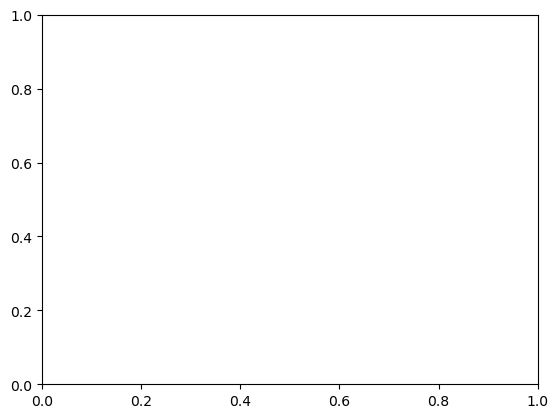

In [67]:
import matplotlib.pyplot as plt
# Création du graphique à barres
values = ["1359", "640", "552", "485"]
plt.bar(films_uniques_genre["type_de_devis"], values )
plt.show()


In [63]:

counts = films_uniques_genre["type_de_devis"].value_counts()
x_labels = counts.index.astype(str)
counts

type_de_devis
catégorie 1    1359
catégorie 2     640
catégorie 3     552
catégorie 4     485
Name: count, dtype: int64

## Nettoyage films avec plusieurs réalisateurs (brouillon)

In [ ]:
 realisateurs = films_cnc["realisateur"].split("/")

In [ ]:
# Initialisation des DataFrames pour les films avec 1 ou plusieurs réalisateurs
films_cnc_1_réalisateur = pd.DataFrame(columns=['titre', 'realisateur', 'producteurs', 'devis', 'genre', 'eof', 'rang',
                                                 'asr', 'payante', 'clair', 'nationalite', 'date', 'decomposition',
                                                 'aides', 'type_de_devis'])
films_cnc_plusieurs_réalisateurs = pd.DataFrame(columns=['titre', 'realisateur', 'producteurs', 'devis', 'genre', 'eof', 'rang',
                                                         'asr', 'payante', 'clair', 'nationalite', 'date', 'decomposition',
                                                         'aides', 'type_de_devis'])

,titre,realisateur,producteurs,devis,genre,eof,rang,asr,payante,clair,nationalite,date,decomposition,aides,type_de_devis


In [ ]:
#Je crée la fonction genre pour les films ayant un unique réalisateur
realisateur_split = films_cnc["realisateur"].str.split(pat='/', expand=True, regex=True)

# Appliquer la logique pour chaque ligne (film)
index_films_uniques = realisateur_split.iloc[:, 1:].applymap(lambda x: pd.isna(x) or x is None).all(axis=1)

# Afficher l'index des films avec un unique réalisateur
print(index_films_uniques)
# Filtrer les films ayant un unique réalisateur
films_uniques = films_cnc.loc[index_films_uniques]

# Afficher la sous-base des films avec un unique réalisateur
print(films_uniques)



In [ ]:
#Cette fonction a pour but de créer une variable genre qui, attribue 'f' aux films réalisés par une femme, 'm' aux films réalisés par un homme, 'f_coréalisé" si le film a été co-réalisé et qu'au moins une femme est dans le projet, sinon "m_coréalisé"
#Pour ce faire, je procède en plusieurs étapes : 

for film in films_cnc: #pour chaque film de ma base
   realisateur_split = films_cnc["realisateur"].str.split(pat='/', expand=True, regex=True)

   for j in range(1,12): #si le film a été réalisé par un unique réalisateur, j'ajoute le film à une base provisoire pour pouvoir appliquer la fonction genre
    if realisateur_split["j"]= None
       films_cnc_1_réalisateur = pd.concat([films_cnc_1_réalisateur, pd.DataFrame([film])], ignore_index=False)
       films_cnc_1_réalisateur['genre']= films_cnc_1_réalisateur['realisateur'].apply(get_genre_prenom)
    else 
    films_cnc_plusieurs_réalisateurs = pd.concat([films_cnc_plusieurs_réalisateurs, pd.DataFrame([film])], ignore_index=False)
    films_cnc_plusieurs_réalisateurs.columns = [f"genre_réalisateur_{i+1}" for i in range(realisateur_split.shape[1])]
    films_cnc_1_réalisateur['genre']= films_cnc_1_réalisateur['realisateur'].apply(get_genre_prenom)
     

    #J'ajoute la variable genre à mes bases
    films_cnc_1_réalisateur_avec_genre = get_genre_individuel(films_cnc_1_réalisateur, 'realisateur', -1)
    
    films_cnc_plusieurs_réalisateurs_final = add_realisateur_columns(films_cnc_plusieurs_réalisateurs)
    films_cnc_plusieurs_réalisateurs_final = get_genre_individuel(????)

    #Je concatène mes deux bases 

return 
  
  films_cnc_1_réalisateur['genre']= films_cnc_1_réalisateur['realisateur'].apply(get_genre_prenom)
  

In [ ]:
#Code fonction genre étape 1
films_cnc_1_réalisateur = pd.DataFrame(columns=['titre', 'realisateur', 'producteurs', 'devis', 'genre', 'eof', 'rang',
                                                 'asr', 'payante', 'clair', 'nationalite', 'date', 'decomposition',
                                                 'aides', 'type_de_devis'])

for film in films_cnc: #pour chaque film de ma base
   realisateur_split = films_cnc["realisateur"].str.split(pat='/', expand=True, regex=True)

   for j in range(1,12): #si le film a été réalisé par un unique réalisateur, j'ajoute le film à une base provisoire pour pouvoir appliquer la fonction genre
     if realisateur_split.iloc[0, 1:].isna().all():
       films_cnc_1_réalisateur = pd.concat([films_cnc_1_réalisateur, pd.DataFrame([film])], ignore_index=False)
   
   return films_cnc_1_réalisateur 

SyntaxError: 'return' outside function (4262285905.py, line 13)

In [31]:

def traiter_films(films_cnc):  # Encapsulation dans une fonction
    films_cnc_1_réalisateur = pd.DataFrame(columns=['titre', 'realisateur', 'producteurs', 'devis', 'genre', 'eof', 'rang',
                                                 'asr', 'payante', 'clair', 'nationalite', 'date', 'decomposition',
                                                 'aides', 'type_de_devis'])

    for film in films_cnc:  # pour chaque film de ma base
        realisateur_split = films_cnc["realisateur"].str.split(pat='/', expand=True, regex=True)

        for j in range(1, 12):  # si le film a été réalisé par un unique réalisateur
            if realisateur_split.iloc[0, 1:].isna().all():
                films_cnc_1_réalisateur = pd.concat([films_cnc_1_réalisateur, pd.DataFrame([film])], ignore_index=False)

    return films_cnc_1_réalisateur  # Correctement placé à l'intérieur de la fonction


In [ ]:
films_cnc_test = traiter_films(films_cnc)
films_cnc_test

In [22]:
realisateur_split = films_cnc["realisateur"].split(pat='/', expand=True, regex=True)
realisateur_split

AttributeError: 'Series' object has no attribute 'split'

In [12]:
get_genre_prenom("Marie")

'f'

In [ ]:
def get_genre_prenom(prenom):
    """
    Retourne le genre associé au prénom donné

    """
    # Import de la base prénom
    base_prenom_genre = base_prenom()
    base_prenom_genre = base_prenom_genre.drop(columns=['04_fréquence', 'langage_ind'])

    # Transformer le prénom en minuscule afin de pas avoir de pb de casse avec les majuscules
    prenom_formate = prenom.lower()

    # Recherche du prénom dans la base
    genre = base_prenom_genre[base_prenom_genre['prenom'].str.lower() == prenom_formate]

    if not genre.empty:
        return genre['genre_ind'].values[0]
    else:
        return 'non trouvé'

In [ ]:
#Fonction à enregistrer dans le dossier dédié
def add_realisateur_columns(df):
    """
   Cette fonction crée une variable par réalisateur (quand ces derniers sont nombreux).
    Elle divise la colonne 'realisateur' par '/' et ajoute une colonne pour chaque réalisateur.
    
    Paramètres :
    df : DataFrame
        Le DataFrame contenant les données avec la colonne 'realisateur'.
   
    Retourne :
    DataFrame avec les nouvelles colonnes pour chaque réalisateur ajoutées.    
    """

    # Création d'un dataframe contenant un realisateur par colonne
    realisateur_split = df["realisateur"].str.split(pat='/', expand=True, regex=True)

    # Renommer les colonnes pour correspondre à "réalisateur_1", "réalisateur_2", etc.
    realisateur_split.columns = [f"réalisateur_{i+1}" for i in range(realisateur_split.shape[1])]

    #Assurer que les index sont en str
    realisateur_split.index = realisateur_split.index.astype(str)
    df.index = df.index.astype(str)
    
    # Fusionner les dataframes
    df_avec_plein_de_real = pd.merge(left= df, right=realisateur_split, left_index=True, right_index=True)
    return df_avec_plein_de_real


In [ ]:

dataframe['prenom'] = dataframe[colonne].str.split().str[position].str.lower()

### Fusion base CNC et base allociné

J'effectue un test pour voir si la base CNC et la base allociné peuvent bien être fusionnées. Je récupère donc ces informations : ttes les infos cnc, les moyennes des notes presse et spectateur allociné. 

In [19]:
#Préparation de la base allociné pour le merge 
base_films_2010 = get_base_films(2010, 2010)
nest_asyncio.apply()
base_films_enrichie_2010 = get_carac_film(base_films_2010)

base_films_enrichie_2010['num_visa'] = base_films_enrichie_2010['num_visa'].str.replace(' ', '')

nombre de films récupérés :  491


In [23]:
inner_merge_cnc_allociné = pd.merge(left = films_cnc , right = base_films_enrichie_2010 , how='inner', left_on="visa", right_on='num_visa')

In [24]:
inner_merge_cnc_allociné

,visa,titre_x,realisateur,producteurs,devis,genre,eof,rang,asr,payante,...,date_sortie_bluray,date_sortie_vod,type_film,budget,langues,format_production,couleur,format_audio,format_projection,num_visa
0,122207,AO LE DERNIER NEANDERTAL,MALATERRE Jacques,FRANCE 2 CINEMA / UGC IMAGES / UGC YM,13398412.0,Fiction,None,1,None,None,...,-,01/12/2016,Long métrage,13 000 000 EUR,Français,-,Couleur,-,-,122207
1,122530,COURSIER,RENOH Hervé,BLACK MASK PRODUCTIONS / EUROPACORP / M6 FILMS...,9410932.0,Fiction,None,2,None,None,...,-,03/12/2019,Long métrage,-,Français,-,Couleur,-,-,122530
2,121405,MEUTE (LA),RICHARD Franck,LA FABRIQUE 2,2866560.0,Fiction,None,1,None,None,...,-,01/01/2016,Long métrage,2 500 000 EUR,Français,-,Couleur,-,-,121405
3,123656,REVOLTES DE L'ILE DU DIABLE (LES),HOLST M.,MACT PRODUCTIONS,5296837.0,Fiction,None,3,None,None,...,24/10/2012,23/03/2012,Long métrage,9 500 000 USD,"Norvégien, Suédois",-,Couleur,-,-,123656
4,120962,TOURNEE,AMALRIC Mathieu,ARTE FRANCE CINEMA / LE PREMIER POISSON,3515910.0,Fiction,None,2,avant,None,...,29/09/2016,30/10/2010,Long métrage,4 150 000 EUR,"Anglais, Français",35mm,Couleur,Dolby Digital,1.85 : 1,120962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,124018,MAMMUTH,KERVERN Gustave / DELEPINE Benoît,ARTE FRANCE CINEMA / DD PRODUCTIONS / GMT PROD...,2499161.0,Fiction,None,3 / 3,None,None,...,-,15/08/2015,Long métrage,2 000 000 USD,Français,35mm,Couleur,Dolby Digital,1.85 : 1,124018
164,121731,TETE AILLEURS (LA),PELLE Frédéric,7EME APACHE FILMS / BIANCA FILMS,1054741.0,Fiction,None,1,None,None,...,-,-,Long métrage,-,Français,-,Couleur,-,-,121731
165,123205,TETE EN FRICHE (LA),BECKER Jean,DD PRODUCTIONS / FRANCE 3 CINEMA / ICE 3 / KJB...,8274491.0,Fiction,None,3,None,None,...,-,23/10/2010,Long métrage,-,"Flamand, Français",35mm,Couleur,"Dolby Digital, DTS",2.35 : 1 Cinemascope,123205
166,122965,UN HOMME QUI CRIE,HAROUN Mahamat-Saleh,PILI FILMS,2066392.0,Fiction,None,3,avant,None,...,-,29/01/2011,Long métrage,2 000 000 EUR,Français,-,Couleur,-,-,122965


## III - Modelisation